### LASSO parameter range experiments: microsatellite instability (MSI) prediction

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
ll_base_results_dir = os.path.join(
    cfg.repo_root, '10_msi_prediction', 'results', 'msi_lasso_range_sex_covariate_lr'
)

# this doesn't have a sex covariate but it's probably close enough
sgd_base_results_dir = os.path.join(
    cfg.repo_root, '10_msi_prediction', 'results', 'msi_lasso_range'
)

training_dataset = 'all_other_cancers'
ll_results_dir = os.path.join(ll_base_results_dir, training_dataset)
sgd_results_dir = os.path.join(sgd_base_results_dir, training_dataset)

metric = 'aupr'

### Get coefficient information for each lasso penalty

In [3]:
ll_nz_coefs_df = []

# get coefficient info for training dataset specified above
for coef_info in au.generate_nonzero_coefficients_lasso_range_msi(ll_results_dir):
    (cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        ll_nz_coefs_df.append(
            [cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
ll_nz_coefs_df = pd.DataFrame(
    ll_nz_coefs_df,
    columns=['cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
ll_nz_coefs_df.lasso_param = ll_nz_coefs_df.lasso_param.astype(float)
ll_nz_coefs_df.head()

,cancer_type,lasso_param,seed,fold,nz_coefs
0,UCEC,0.001,42,0,0
1,UCEC,0.001,42,1,0
2,UCEC,0.001,42,2,0
3,UCEC,0.001,42,3,0
4,UCEC,1500.000,1,0,8392


In [4]:
sgd_nz_coefs_df = []

# get coefficient info for training dataset specified above
for coef_info in au.generate_nonzero_coefficients_lasso_range_msi(sgd_results_dir):
    (cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        sgd_nz_coefs_df.append(
            [cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
sgd_nz_coefs_df = pd.DataFrame(
    sgd_nz_coefs_df,
    columns=['cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
sgd_nz_coefs_df.lasso_param = sgd_nz_coefs_df.lasso_param.astype(float)
sgd_nz_coefs_df.head()

,cancer_type,lasso_param,seed,fold,nz_coefs
0,UCEC,1.000000e-08,1,0,16149
1,UCEC,1.000000e-08,1,1,16149
2,UCEC,1.000000e-08,1,2,16149
3,UCEC,1.000000e-08,1,3,16149
4,COAD,1.000000e-08,1,0,16149


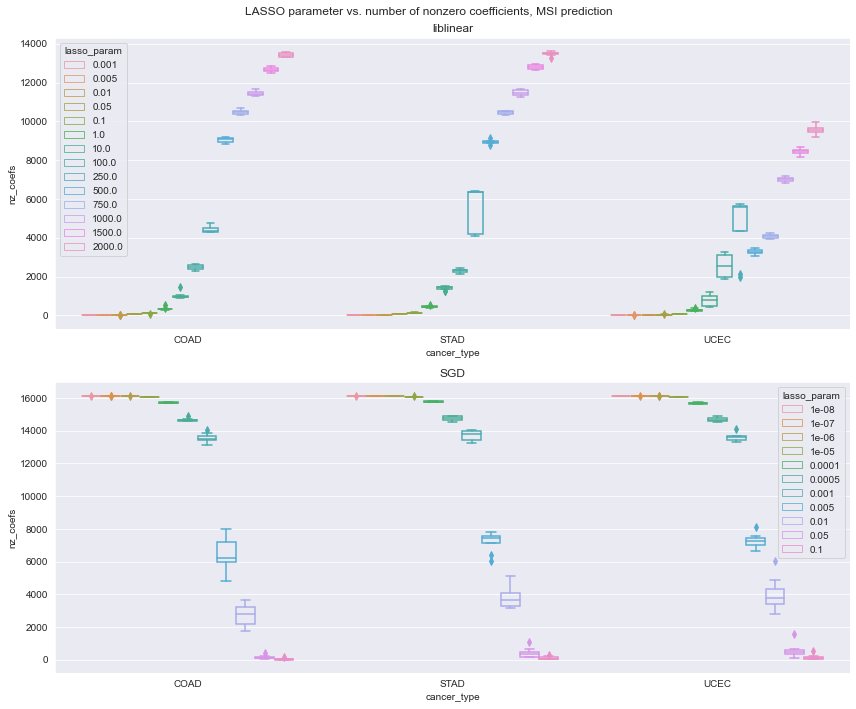

In [5]:
sns.set({'figure.figsize': (12, 10)})
fig, axarr = plt.subplots(2, 1)

def color_boxplot_edges(ax):
    # color the boxplot lines/edges rather than the box fill
    # this makes it easier to discern colors at the extremes; i.e. very many or few nonzero coefs
    # https://stackoverflow.com/a/72333641
    box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
    num_patches = len(box_patches)
    lines_per_boxplot = len(ax.lines) // num_patches
    for i, patch in enumerate(box_patches):
        # set the linecolor on the patch to the facecolor, and set the facecolor to None
        col = patch.get_facecolor()
        patch.set_edgecolor(col)
        patch.set_facecolor('None')

        # each box has associated Line2D objects (to make the whiskers, fliers, etc.)
        # loop over them here, and use the same color as above
        for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
            line.set_color(col)
            line.set_mfc(col)  # facecolor of fliers
            line.set_mec(col)  # edgecolor of fliers

    # also fix the legend to color the edges rather than fill
    for legpatch in ax.legend_.get_patches():
        col = legpatch.get_facecolor()
        legpatch.set_edgecolor(col)
        legpatch.set_facecolor('None')


sns.boxplot(
    data=ll_nz_coefs_df.sort_values(by=['cancer_type', 'lasso_param']),
    x='cancer_type', y='nz_coefs', hue='lasso_param', ax=axarr[0]
)
color_boxplot_edges(axarr[0])
axarr[0].set_title('liblinear')

sns.boxplot(
    data=sgd_nz_coefs_df.sort_values(by=['cancer_type', 'lasso_param']),
    x='cancer_type', y='nz_coefs', hue='lasso_param', ax=axarr[1]
)
color_boxplot_edges(axarr[1])
axarr[1].set_title('SGD')

plt.suptitle(f'LASSO parameter vs. number of nonzero coefficients, MSI prediction')
plt.tight_layout()

### Get performance information for each lasso penalty

TODO: explain quantiles

In [6]:
# load performance information
ll_perf_df = au.load_prediction_results_lasso_range_msi(ll_results_dir, 'liblinear')
ll_perf_df.drop(columns=['gene'], inplace=True)
ll_perf_df.rename(columns={'experiment': 'optimizer'}, inplace=True)
ll_perf_df.lasso_param = ll_perf_df.lasso_param.astype(float)

ll_perf_df.head()

,auroc,aupr,holdout_cancer_type,signal,seed,data_type,fold,optimizer,lasso_param
0,1.00000,1.00000,UCEC,signal,1,train,0,liblinear,1.0
1,0.92253,0.92050,UCEC,signal,1,test,0,liblinear,1.0
2,0.99200,0.97862,UCEC,signal,1,cv,0,liblinear,1.0
3,1.00000,1.00000,UCEC,signal,1,train,1,liblinear,1.0
4,0.97143,0.95249,UCEC,signal,1,test,1,liblinear,1.0


In [7]:
# add nonzero coefficient count
ll_plot_df = (
    ll_perf_df[(ll_perf_df.signal == 'signal')]
      .merge(ll_nz_coefs_df, left_on=['holdout_cancer_type', 'lasso_param', 'seed', 'fold'],
             right_on=['cancer_type', 'lasso_param', 'seed', 'fold'])
      .drop(columns=['cancer_type'])
      .sort_values(by=['holdout_cancer_type', 'lasso_param'])
      .reset_index(drop=True)
)
ll_plot_df.lasso_param = ll_plot_df.lasso_param.astype(float)

print(ll_plot_df.shape)
ll_plot_df.head()

(1008, 10)


,auroc,aupr,holdout_cancer_type,signal,seed,data_type,fold,optimizer,lasso_param,nz_coefs
0,0.5,0.23994,COAD,signal,1,train,0,liblinear,0.001,0
1,0.5,0.17647,COAD,signal,1,test,0,liblinear,0.001,0
2,0.5,0.22321,COAD,signal,1,cv,0,liblinear,0.001,0
3,0.5,0.23696,COAD,signal,1,train,1,liblinear,0.001,0
4,0.5,0.20000,COAD,signal,1,test,1,liblinear,0.001,0


In [8]:
# load performance information
sgd_perf_df = au.load_prediction_results_lasso_range_msi(sgd_results_dir, 'sgd')
sgd_perf_df.drop(columns=['gene'], inplace=True)
sgd_perf_df.rename(columns={'experiment': 'optimizer'}, inplace=True)
sgd_perf_df.lasso_param = sgd_perf_df.lasso_param.astype(float)

sgd_perf_df.head()

,auroc,aupr,holdout_cancer_type,signal,seed,data_type,fold,optimizer,lasso_param
0,1.00000,1.00000,STAD,signal,1,train,0,sgd,1.000000e-07
1,0.99238,0.97616,STAD,signal,1,test,0,sgd,1.000000e-07
2,0.96792,0.93647,STAD,signal,1,cv,0,sgd,1.000000e-07
3,1.00000,1.00000,STAD,signal,1,train,1,sgd,1.000000e-07
4,0.96250,0.90091,STAD,signal,1,test,1,sgd,1.000000e-07


In [9]:
# add nonzero coefficient count
sgd_plot_df = (
    sgd_perf_df[(sgd_perf_df.signal == 'signal')]
      .merge(sgd_nz_coefs_df, left_on=['holdout_cancer_type', 'lasso_param', 'seed', 'fold'],
             right_on=['cancer_type', 'lasso_param', 'seed', 'fold'])
      .drop(columns=['cancer_type'])
      .sort_values(by=['holdout_cancer_type', 'lasso_param'])
      .reset_index(drop=True)
)
sgd_plot_df.lasso_param = sgd_plot_df.lasso_param.astype(float)

print(sgd_plot_df.shape)
sgd_plot_df.head()

(792, 10)


,auroc,aupr,holdout_cancer_type,signal,seed,data_type,fold,optimizer,lasso_param,nz_coefs
0,1.00000,1.00000,COAD,signal,42,train,0,sgd,1.000000e-08,16148
1,0.99893,0.99451,COAD,signal,42,test,0,sgd,1.000000e-08,16148
2,0.94781,0.89110,COAD,signal,42,cv,0,sgd,1.000000e-08,16148
3,1.00000,1.00000,COAD,signal,42,train,1,sgd,1.000000e-08,16149
4,0.99909,0.99632,COAD,signal,42,test,1,sgd,1.000000e-08,16149


In [10]:
plot_df = pd.concat((ll_plot_df, sgd_plot_df)).reset_index(drop=True)

print(plot_df.shape)
print(plot_df.optimizer.unique())
plot_df.head()

(1800, 10)
['liblinear' 'sgd']


,auroc,aupr,holdout_cancer_type,signal,seed,data_type,fold,optimizer,lasso_param,nz_coefs
0,0.5,0.23994,COAD,signal,1,train,0,liblinear,0.001,0
1,0.5,0.17647,COAD,signal,1,test,0,liblinear,0.001,0
2,0.5,0.22321,COAD,signal,1,cv,0,liblinear,0.001,0
3,0.5,0.23696,COAD,signal,1,train,1,liblinear,0.001,0
4,0.5,0.20000,COAD,signal,1,test,1,liblinear,0.001,0


0.100 4.000000
0.200 84.800000
0.300 438.300000
0.400 2632.800000
0.500 5929.500000
0.600 9196.000000
0.700 13292.000000
0.800 15055.200000
0.900 16140.000000


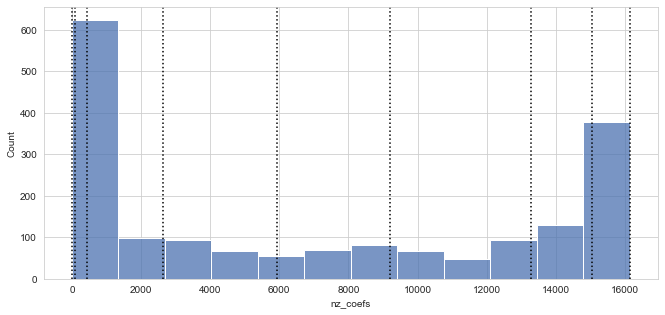

In [18]:
sns.set({'figure.figsize': (11, 5)})
sns.set_style('whitegrid')

sns.histplot(plot_df.nz_coefs)
for q in np.linspace(0.1, 0.9, 9):
    print(f'{q:.3f}', f'{plot_df.nz_coefs.quantile(q):3f}')
    plt.gca().axvline(x=plot_df.nz_coefs.quantile(q), color='black', linestyle=':')

In [12]:
plot_df['nz_quantile'] = pd.qcut(
    plot_df.nz_coefs,
    q=np.linspace(0, 1, 11),
    labels=[f'{q}' for q in range(1, 11)]
)

print(plot_df.nz_quantile.unique())
plot_df.head()

['1', '2', '3', '4', '5', '6', '7', '8', '10', '9']
Categories (10, object): ['1' < '2' < '3' < '4' ... '7' < '8' < '9' < '10']


,auroc,aupr,holdout_cancer_type,signal,seed,data_type,fold,optimizer,lasso_param,nz_coefs,nz_quantile
0,0.5,0.23994,COAD,signal,1,train,0,liblinear,0.001,0,1
1,0.5,0.17647,COAD,signal,1,test,0,liblinear,0.001,0,1
2,0.5,0.22321,COAD,signal,1,cv,0,liblinear,0.001,0,1
3,0.5,0.23696,COAD,signal,1,train,1,liblinear,0.001,0,1
4,0.5,0.20000,COAD,signal,1,test,1,liblinear,0.001,0,1


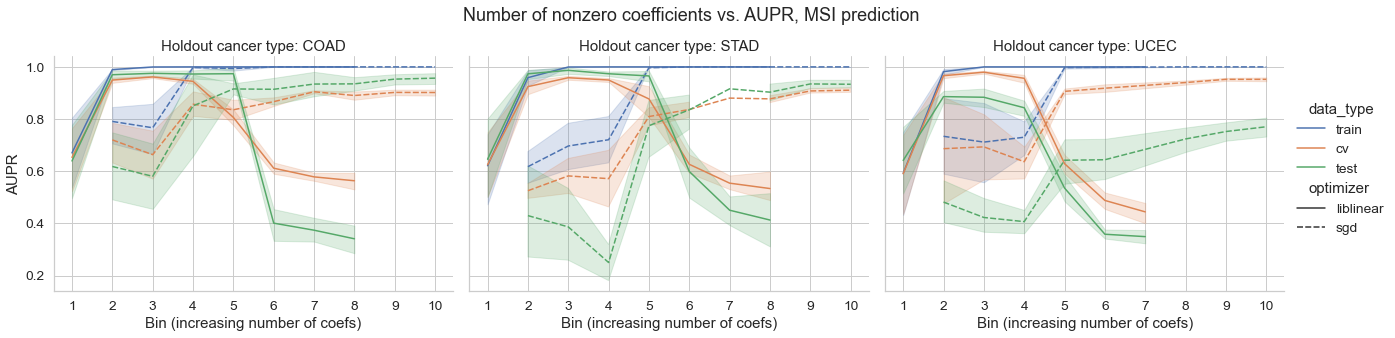

In [14]:
# compare optimizers for MSI prediction on the same plot
sns.set_style('whitegrid')

with sns.plotting_context('notebook', font_scale=1.25):
    g = sns.relplot(
        data=plot_df,
        x='nz_quantile', y=metric,
        hue='data_type', hue_order=['train', 'cv', 'test'],
        style='optimizer', style_order=['liblinear', 'sgd'],
        kind='line', col='holdout_cancer_type',
        col_wrap=3, height=4.5, aspect=1.35
    )
    g.set_titles('Holdout cancer type: {col_name}')
    g.set_xlabels('Bin (increasing number of coefs)')
    g.set_ylabels(f'{metric.upper()}')
    plt.suptitle(f'Number of nonzero coefficients vs. {metric.upper()}, MSI prediction', y=1.05)